<img src="../images/bikes_banner.jpg" width="1000" />

# <span style="color:#37535e">Initial EDA for Bicycle Share Usage Project</span>

##  <span style='color:#3b748a'>Basic EDA for July 2018 data from Relay Atlanta</span>

<span style='color:#4095b5'>This notebook performs initial explorations of one month (July 2018) of data from the Atlanta bike share system to better understand potential issues which may be encountered while standardizing the numerous data sets over various cities and for larger periods of time.</span>

## <span style='color:#3b748a'>Table of contents</span>
<ul>
    <li><span style='color:#4095b5'>I.  <a href="#checking"><span style='color:#4095b5'>Data checking functions.</span></a></span></li>
    <li><span style='color:#4095b5'>II. <a href="#cleaning"><span style='color:#4095b5'>Data cleaning functions.</span></a></span></li>
    <li><span style='color:#4095b5'>III. <a href="#data"><span style='color:#4095b5'>Obtain the data.</span></a></span></li>
    <li><span style='color:#4095b5'>IV. <a href="#dict"><span style='color:#4095b5'>Explore the data dictionary.</span></a></span></li>
    <li><span style='color:#4095b5'>V. <a href="#clean"><span style='color:#4095b5'>Clean the data.</span></a></span></li>
    <li><span style='color:#4095b5'>VI. <a href="#plot"><span style='color:#4095b5'>Plot some of the data.</span></a></span></li>
</ul>

## <span style='color:#3b748a'>External data required</span>
<ul>
    <li><span style='color:#4095b5'><a href="../data/atl/trips_201807.csv"><span style='color:#4095b5'>../data/atl/trips_201807.csv</span></a> (available in GitHub)</span></li>
</ul>

## <span style='color:#3b748a'>Links</span>
<ul>
    <li><a href="http://relaybikeshare.com/system-data/"><span style='color:#4095b5'>Atlanta Relay data</span></a></li>
</ul>

In [63]:
# Let's get the administrative stuff done first
# import all the libraries and set up the plotting

import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from geopy.distance import vincenty

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# GnBu_d
colors = ['#37535e', '#3b748a', '#4095b5', '#52aec9', '#72bfc4', '#93d0bf']

<hr>
<a name="checking"> </a>
## <span style='color:#3b748a'>I. Data checking functions</span>

In [64]:
# Check which non-numeric columns are missing values and what the possible values are for each object column

def check_cols(df):
    cols = df.select_dtypes([np.object]).columns
    for col in cols:
        print("{} is {} and values are {}.".format(col,df[col].dtype,df[col].unique()))
        n_nan = df[col].isnull().sum()
        if n_nan > 0:
            print("{} has {} NaNs".format(col,n_nan))
            
    cols = df.select_dtypes([np.int64,np.float64,np.uint64]).columns
    for col in cols:
        print("{} is {} and values are {} to {}.".format(col,df[col].dtype,df[col].min(),df[col].max()))
        n_nan = df[col].isnull().sum()
        if n_nan > 0:
            print("{} has {} NaNs".format(col,n_nan))
    return

In [65]:
# Check which numeric columns are missing values

def check_data(df):
    s = df.shape

    # Check for null values
    null_data = df.isnull().sum()
    null_data_count = sum(null_data)
    print("Rows: {}\t Cols: {}\t NaNs: {}".format(s[0],s[1],null_data_count))
    if  null_data_count > 0:
        print("Columns with NaN: {}".format(list(null_data[null_data > 0].index)))

    return

<hr>
<a name="cleaning"></a>
## <span style='color:#3b748a'> II. Data cleaning functions</span>

<span style='color:#4095b5'>These functions clean the trip data.</span>

### <span style='color:#4095b5'>Drop most of the columns.</span>
<span style='color:#52aec9'>As I understand the data more and want to do more modeling, I may choose to drop fewer columns. Many of these are not used yet by Relay.</span>

In [66]:
def drop_columns(df):
    cols_drop = ['User ID', 'Route ID', 'Payment Plan', 'Bike ID', 'Member Type', 'Start Area',
                 'End Area', 'Ride cost', 'Fees', 'Bonuses', 'Total cost','Multiple Rental',
                 'Trip Type','Rental Access Path','Bike Region ID','Start Special Area',
                 'End Special Area']

    # Can't drop a column that isn't there
    cols_drop = list(set(df.columns) & set(cols_drop))
    df.drop(cols_drop, axis=1, inplace=True)

    return df

### <span style='color:#4095b5'>Drop rows with nulls.</span>
<span style='color:#52aec9'>Don't have any to drop right now. Replace NaN is Hubs with 'NONE'.</span>

In [67]:
def drop_nans(df):
    df['Start Hub'] = df['Start Hub'].fillna('NONE')
    df['End Hub'] = df['End Hub'].fillna('NONE')

    return df

### <span style='color:#4095b5'>Use appropriate datatypes.</span>
<span style='color:#52aec9'>For example, fix Date/Time objects and cast Latitude and Longitude to floats.</span>

In [68]:
def clean_datatypes(df):
    df['Start Latitude'] = df['Start Latitude'].astype(float)
    df['Start Longitude'] = df['Start Longitude'].astype(float)
    df['End Latitude'] = df['End Latitude'].astype(float)
    df['End Longitude'] = df['End Longitude'].astype(float)

    # Turn times in datetime
    df['Start Time'] = pd.to_datetime(df['Start Date'] + ' ' + df['Start Time'])
    df['End Time'] = pd.to_datetime(df['End Date'] + ' ' + df['End Time'])

    # Turn dates in datetime
    df['Start Date'] = pd.to_datetime(df['Start Date'])
    df['End Date'] = pd.to_datetime(df['End Date'])

    # Fix the durations
    df['Duration'] = pd.to_timedelta(df['Duration'])
    
    return df

### <span style='color:#4095b5'>Drop trivial trips.</span>
<span style='color:#52aec9'>Trivial trips are of short length or the trip time is less than 3 mins. Further exploration might be needed.</span>

In [69]:
def drop_trivial_trips_distance(df):
    df = df[df["Distance [Miles]"] > 0.02].copy()
    return df

In [70]:
def drop_trivial_trips_duration(df):
    df = df[df["Duration"] >= pd.to_timedelta('00:03:00')].copy()
    return df

In [71]:
def drop_trivial_trips(df):
    df = drop_trivial_trips_distance(df)
    df = drop_trivial_trips_duration(df)
    return df

### <span style='color:#4095b5'>Drop outliers.</span>
<ul>
    <li><span style='color:#52aec9'>Some of the ATL bikes are reported to be in Athens or in NYC.</span></li> 
    <li><span style='color:#52aec9'>One ATL bike was out for 36 days; 174 trips were for longer than 24 hours.</span></li> 
    <li><span style='color:#52aec9'>One ATL bike went 3913.01 miles.</span></li> 
</ul>

In [72]:
def drop_outliers_latlon(df):
    df = df[df["Start Latitude"] < 33.9].copy()
    df = df[df["End Latitude"] < 33.9].copy()
    df = df[df["Start Latitude"] > 33.5].copy()
    df = df[df["End Latitude"] > 33.5].copy()

    df = df[df["Start Longitude"] < -83.0].copy()
    df = df[df["End Longitude"] < -83.0].copy()

    return df

In [73]:
def drop_outliers_duration(df):
    df = df[df["Duration"] <= pd.to_timedelta('24:00:00')].copy()
    return df

In [74]:
def drop_outliers_distance(df):
    df = df[df["Distance [Miles]"] < 100.0].copy()
    return df

In [75]:
def drop_outliers(df):
    df = drop_outliers_latlon(df)
    df = drop_outliers_duration(df)
    df = drop_outliers_distance(df)

    return df

### <span style='color:#4095b5'>Pull all of the cleaning together.</span>

In [76]:
def clean_df(df, df_hubs=None):
    df = drop_columns(df)
    df = drop_nans(df)
    df = clean_datatypes(df)
    df = drop_trivial_trips(df)
    df = drop_outliers(df)
    return df

<hr>
<a name="data"></a>
## <span style="color:#37535e">III. Obtain the data.</span>
 
<span style='color:#3b748a'>Each row (observation) data describes each bike ride on which a Relay bike is taken. Each trip includes a starting place and time, a ending place and time, as well as distance, user, and bike information. We have 11 months worh of data to use for Atlanta.</span>

* <span style='color:#3b748a'><a href="http://relaybikeshare.com/system-data/">Relay (Atlanta) Data</a></span>

In [77]:
df = pd.read_csv("../data/atl/trips_201807.csv")
df.shape

(10986, 30)

In [78]:
df.columns

Index(['User ID', 'Route ID', 'Bike Region ID', 'Payment Plan', 'Start Hub',
       'Start Area', 'Start Special Area', 'Start Latitude', 'Start Longitude',
       'Start Date', 'Start Time', 'End Hub', 'End Area', 'End Special Area',
       'End Latitude', 'End Longitude', 'End Date', 'End Time', 'Member Type',
       'Trip Type', 'Bike ID', 'Bike Name', 'Distance [Miles]', 'Duration',
       'Rental Access Path', 'Multiple Rental', 'Ride cost', 'Fees', 'Bonuses',
       'Total cost'],
      dtype='object')

<hr>
<a name="dict"></a>
## <span style="color:#37535e">IV. Explore the data dictionary for July 2018 in Atlanta</span>
<span style='color:#3b748a'>Each row describes a "trip" on a bicycle.
<ul>
    <li><span style='color:#4095b5'><b>User ID:</b> A six digit integer ID, unique per user.</span></li>
    <li><span style='color:#4095b5'><b>Route ID:</b> A seven digit integer ID, uniqque for each "trip".</span></li>
    <li><span style='color:#4095b5'><b>Bike Region ID:</b> All NaNs; not useful.</span></li>
    <li><span style='color:#4095b5'><b>Payment Plan:</b> String describing payemnt plan; includes corporate plans, monthly subscriptions, studentd subscriptions, etc.</span></li>
    <li><span style='color:#3b748a'><b>Start Hub:</b> String describing starting hubs/virtual hubs.</span></li>
    <li><span style='color:#4095b5'><b>Start Area:</b> String, either NaN or "Relay System".</span></li>
    <li><span style='color:#4095b5'><b>Start Special Area:</b> All NaNs; not useful.</span></li>
    <li><span style='color:#3b748a'><b>Start Latitude:</b> String with latitude of starting point.</span></li>
    <li><span style='color:#3b748a'><b>Start Longitude:</b> String with longitude of starting point.</span></li>
    <li><span style='color:#3b748a'><b>Start Date</b> Date that the trip starts (string).</span></li>
    <li><span style='color:#3b748a'><b>Start Time</b> Time that the trip starts (string).</span></li>
    <li><span style='color:#3b748a'><b>End Hub</b> String describing ending hubs/virtual hubs.</span></li>
    <li><span style='color:#4095b5'><b>End Area</b> String, either NaN or "Relay System".</span></li>
    <li><span style='color:#4095b5'><b>End Special Area</b> All NaNs; not useful.</span></li>
    <li><span style='color:#3b748a'><b>End Latitude</b> String with latitude of ending point.</span></li>
    <li><span style='color:#3b748a'><b>End Longitude</b> String with longitude of ending point.</span></li>
    <li><span style='color:#3b748a'><b>End Date:</b> Date that the trip ends.</span></li>
    <li><span style='color:#3b748a'><b>End Time:</b> Time that the trip ends.</span></li>
    <li><span style='color:#4095b5'><b>Member Type:</b> "User" or "Admin".</span></li>
    <li><span style='color:#4095b5'><b>Trip Type:</b> 'commute', 'recreation', etc.</span></li>
    <li><span style='color:#3b748a'><b>Bike ID:</b> 5-digit integer ID</span></li>
    <li><span style='color:#4095b5'><b>Bike Name:</b> String with 4 digit # and maybe an asterisk.</span></li>
    <li><span style='color:#3b748a'><b>Distance (Miles):</b> Floating point describing distance.</span></li>
    <li><span style='color:#3b748a'><b>Duration:</b> Time that the trip lasts (string).</span></li>
    <li><span style='color:#4095b5'><b>Rental Access Path:</b> String describing how user rented bike (web, mobile, keypad).</span></li>
    <li><span style='color:#4095b5'><b>Multiple Rental:</b> Boolean True/False. Not sure.</span></li>
    <li><span style='color:#4095b5'><b>Ride cost:</b> All are 0.0; not useful.</span></li>
    <li><span style='color:#4095b5'><b>Fees:</b> All are 0.0; not useful.</span></li>
    <li><span style='color:#4095b5'><b>Bonuses:</b> All are 0.0; not useful.</span></li>
    <li><span style='color:#4095b5'><b>Total cost:</b> All are 0.0; not useful.</span></li>
</ul>

<hr>
<a name="clean"></a>
## <span style='color:#3b748a'>V. Clean the data for July 2018 in Atlanta</span>
<ul>
    <li><span style='color:#4095b5'>For now, drop most of the columns.</span></li>
    <li><span style='color:#4095b5'>Drop the trivial trips.</span></li>
    <li><span style='color:#4095b5'>Drop the outliers.</span></li>
    <li><span style='color:#4095b5'>Use appropriate coumn types.</span></li>
</ul>

In [79]:
df = clean_df(df)
check_data(df)
df.columns

Rows: 10384	 Cols: 13	 NaNs: 0


Index(['Start Hub', 'Start Latitude', 'Start Longitude', 'Start Date',
       'Start Time', 'End Hub', 'End Latitude', 'End Longitude', 'End Date',
       'End Time', 'Bike Name', 'Distance [Miles]', 'Duration'],
      dtype='object')

<hr>
<a name="plot"></a>
## <span style='color:#3b748a'>VI. Plot some of the data for July 2018 in Atlanta.</span>
<ul>
    <li> <span style='color:#4095b5'>Number of times a bike leaves each station.</span> </li>
    <li> <span style='color:#4095b5'>Number of times a bike arrives at each station.</span> </li>
</ul>   

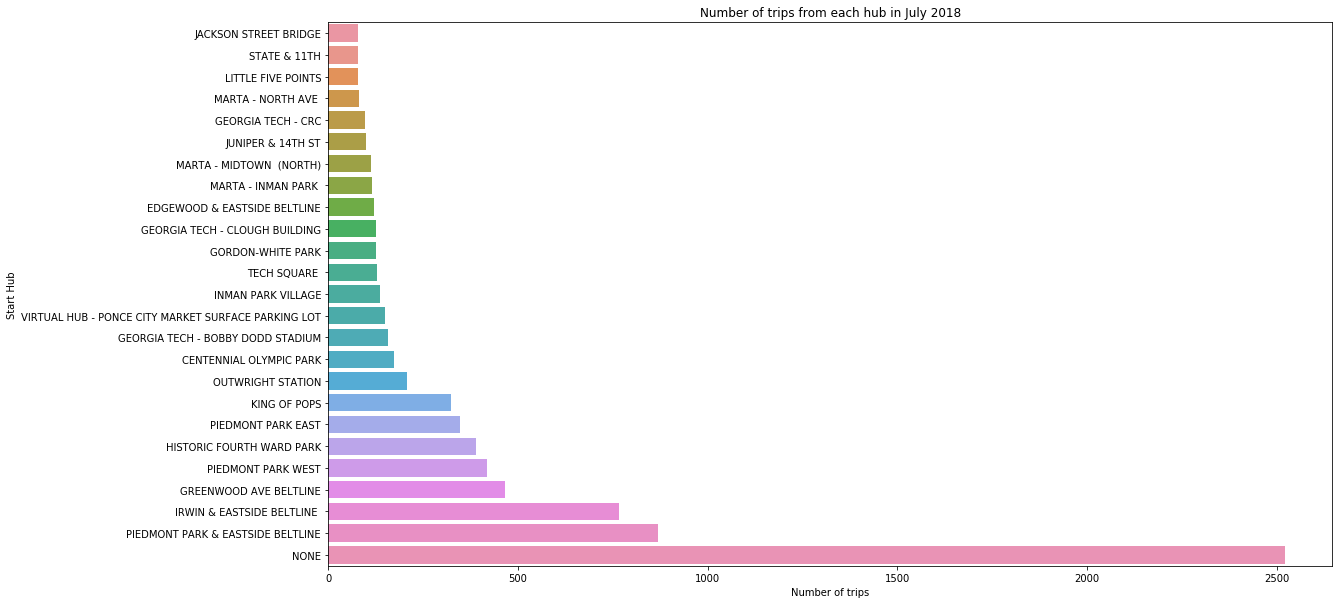

In [80]:
# Plot start stations
df_temp = pd.DataFrame(df.groupby(['Start Hub']).size(), columns=['count'])
df_temp = df_temp[df_temp['count'] > 75].copy()
df_temp.sort_values('count', inplace=True)

fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x=df_temp['count'], y=df_temp.index, ax=ax);
ax.set_xlabel("Number of trips")
ax.set_title("Number of trips from each hub in July 2018");

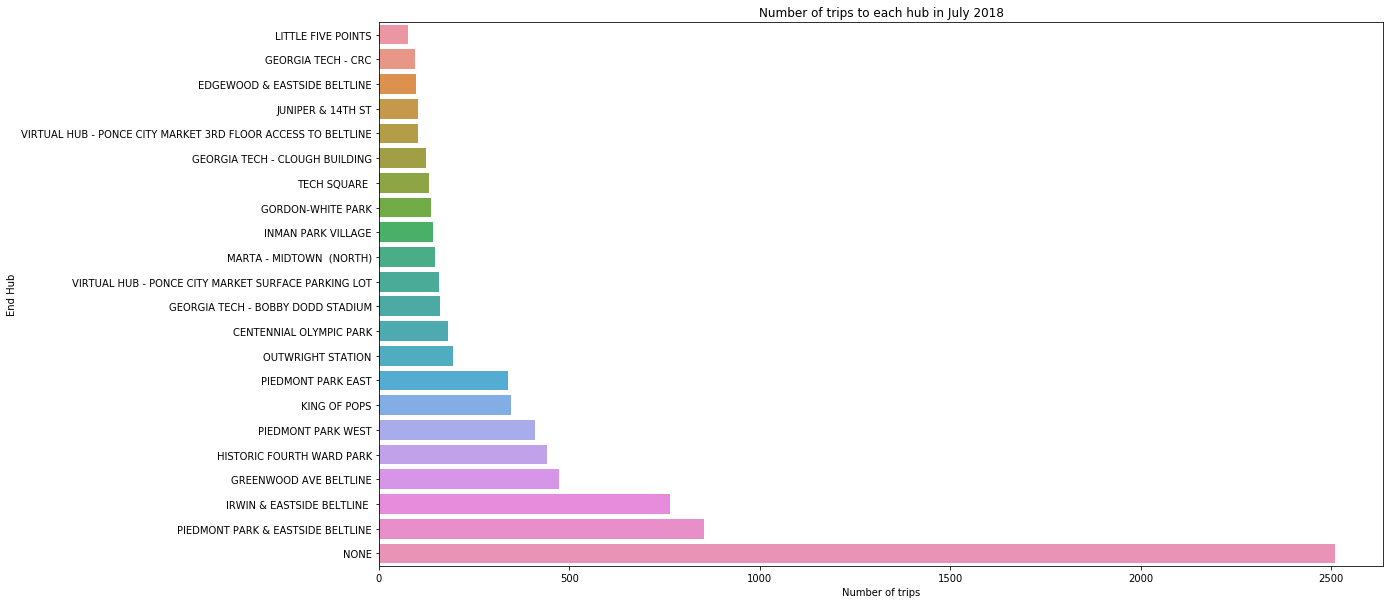

In [81]:
# Plot end stations
df_temp = pd.DataFrame(df.groupby(['End Hub']).size(), columns=['count'])
df_temp = df_temp[df_temp['count'] > 75].copy()
df_temp.sort_values('count', inplace=True)

fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x=df_temp['count'], y=df_temp.index, ax=ax);
ax.set_xlabel("Number of trips")
ax.set_title("Number of trips to each hub in July 2018");

In [82]:
df.describe()

,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance [Miles],Duration
count,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384
mean,33.770910,-84.375084,33.771078,-84.374571,2.330791,0 days 00:36:22.533994
std,0.014681,0.015504,0.014661,0.015533,2.068197,0 days 00:47:57.271945
min,33.719245,-84.442350,33.719135,-84.436015,0.030000,0 days 00:03:00
25%,33.759505,-84.385714,33.759887,-84.384312,1.030000,0 days 00:12:17
50%,33.772382,-84.369860,33.772437,-84.369847,1.830000,0 days 00:26:03.500000
75%,33.782208,-84.364760,33.782050,-84.364688,3.080000,0 days 00:47:51
max,33.876493,-84.266263,33.876453,-84.266423,93.230000,0 days 22:27:07


In [83]:
df.head()

,Start Hub,Start Latitude,Start Longitude,Start Date,Start Time,End Hub,End Latitude,End Longitude,End Date,End Time,Bike Name,Distance [Miles],Duration
1,VIRTUAL HUB - CARVER MARKET,33.719245,-84.385253,2018-07-17,2018-07-17 08:47:00,VIRTUAL HUB - CARVER MARKET,33.719135,-84.385170,2018-07-17,2018-07-17 09:51:00,2900,4.94,01:04:50
2,VIRTUAL HUB - CARVER MARKET,33.719412,-84.385407,2018-07-19,2018-07-19 08:49:00,VIRTUAL HUB - CARVER MARKET,33.719148,-84.385170,2018-07-19,2018-07-19 10:00:00,2900,6.42,01:11:20
3,NONE,33.721688,-84.381058,2018-07-16,2018-07-16 10:23:00,VIRTUAL HUB - CARVER MARKET,33.719140,-84.385168,2018-07-16,2018-07-16 10:29:00,2900,0.62,00:06:23
4,NONE,33.725755,-84.412540,2018-07-04,2018-07-04 09:55:00,MARTA - WEST END,33.736975,-84.413768,2018-07-04,2018-07-04 10:10:00,2838,1.35,00:14:38
5,NONE,33.725878,-84.412657,2018-07-04,2018-07-04 09:55:00,MARTA - WEST END,33.736967,-84.413752,2018-07-04,2018-07-04 10:09:00,2809,1.37,00:13:45
